In [1]:
import os
import glob
import itertools
import string
from os import path
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import textract
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy import displacy

In [2]:
# Our set of whitelisted words
from whitelist import whitelist

# Utils

In [3]:
def freq_dist_to_csv(fd, name):
    df = pd.DataFrame(fd.most_common())
    df.columns = ["word", "freq"]
    df.to_csv(path.join("processed", name + ".csv"))

In [17]:
stop_words = set()
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({
    "purdue",
    "@",
    "et",
    "al",
    "j",
    "patient",
    "patients",
    "n",
    "england",
    "journal",
    "download",
    "downloaded",
    "university",
    "copyright",
    "use",
    "medical",
    "data",
    "however",
    "mers-cov",
    "..",
    "health",
    "april", 
    "study",
    "⫾"
})

digits_re = re.compile(r"\w?\d+\w?")

lemmatizer = nltk.stem.WordNetLemmatizer()

def get_tokens_from_text(text, filter_stopwords = True, use_whitelist = False):
    tokens = []
    
    iterator = nltk.tokenize.word_tokenize(text)
    iterator = map(lambda x: x.lower(), iterator)
    
    if filter_stopwords:
        iterator = filter(lambda x: x not in stop_words and not digits_re.fullmatch(x), iterator)
        
    if use_whitelist:
        iterator = filter(lambda x: x in whitelist, iterator)
    
    for token in iterator:
        tokens.append(token)
            
    return tokens

def get_bigrams_from_text(text, lemmatize = False, filter_stopwords = True, use_whitelist = False, use_lower_upper = False):
    tokens = []
    
    iterator = nltk.tokenize.word_tokenize(text)
    iterator = map(lambda x: x.lower(), iterator)
    
    if lemmatize:
        iterator = map(lambda x: lemmatizer.lemmatize(x), iterator)
        
    iterator = nltk.bigrams(iterator)
    
    if use_lower_upper:
        iterator = filter(lambda x: x[0] in {"lower", "upper", "higher", "increase", "decrease"}, iterator)
    
    for token in iterator:
        keep_bigram = True
        
        if filter_stopwords:
            keep_bigram = all(map(lambda x: x not in stop_words and not digits_re.fullmatch(x), token))
        
        if use_whitelist:
            keep_bigram = any(map(lambda x: x in whitelist, token))
        
        if keep_bigram:
            tokens.append(" ".join(token))
            
    return tokens

In [5]:
def save_text_file(text, name):
    with open(path.join("text", name + ".txt"), "w") as f:
        f.write(text)

# Processing

In [6]:
def load_data():
    pdfs = glob.glob('./papers/*/*')
    pdfs_text = {}
    for pdf in pdfs:
        category = pdf.split("/")[2]
        paper_name = pdf.split("/")[3]
        pdfs_text[(category, paper_name)] = textract.process(pdf).decode("utf-8").lower()
        
    return pdfs_text

In [11]:
def get_frequencies_by_category(pdfs_text, use_bigrams = False, **kwargs):
    tokens_by_category = defaultdict(list)

    for key in pdfs_text:
        category, _ = key
        text = pdfs_text[key]
        
        if not use_bigrams:
            tokens_by_category[category] += get_tokens_from_text(text, **kwargs)
        else:
            tokens_by_category[category] += get_bigrams_from_text(text, **kwargs)

    frequencies_by_category = {}
    for category in tokens_by_category:
        frequencies_by_category[category] = nltk.FreqDist(tokens_by_category[category])
        
    return frequencies_by_category

In [8]:
def dump_frequencies_by_category(frequencies_by_category, prefix):
    for category in frequencies_by_category:
        freq_dist_to_csv(frequencies_by_category[category], prefix + '_' + category)

# Plots
## Helper functions

In [24]:
def plot_bars(df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.20
    ind = np.arange(df.shape[0])
    
    plt.bar(ind - width, df.vaping, width, label="Vaping")
    plt.bar(ind, df.ards, width, label="ARDS")
    plt.bar(ind + width, df.mers, width, label="MERS")
    
    ax.set_xticks(ind + width / 2)
    
    ax.set_xticklabels(df.word, rotation=40)
    
    ax.autoscale_view()
    ax.legend()
    ax.set_title(title, fontdict={"fontsize": 15, "fontweight": 2})
    ax.set_ylabel("Relative Frequency")
    ax.set_xlabel("Words")
    plt.tight_layout()

In [9]:
def aggregate_data(frequencies_by_category, scale_by_category = True):

    total_df = None

    for category in frequencies_by_category:
        freqs = frequencies_by_category[category].most_common()
        df = pd.DataFrame(freqs)
        df.columns = ['word', category]
        
        if scale_by_category:
            df[category] /= df[category].sum()

        if isinstance(total_df, type(None)):
            total_df = df
        else:
            total_df = pd.merge(total_df, df, on="word", how="outer").fillna(0, downcast='infer')

    total_df['sum'] = total_df['vaping'] + total_df['ards'] + total_df['mers']
    total_df = total_df.sort_values(by="sum", ascending=False)
    
    return total_df

## Actual plots

In [10]:
pdfs_text = load_data()

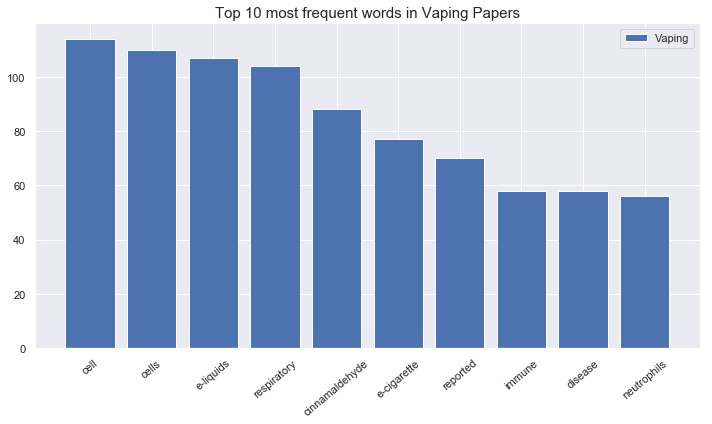

In [21]:
frequencies_by_category = get_frequencies_by_category(pdfs_text)
total_df = aggregate_data(frequencies_by_category, scale_by_category=False)

total_df = total_df.sort_values(by="vaping", ascending=False)

df = total_df[:10] # Take top 10
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(df.word, rotation=40)
ax.set_title("Top 10 most frequent words in Vaping Papers", 
             fontdict={"fontsize": 15, "fontweight": 2})
plt.bar(df.word, df.vaping, label="Vaping")
ax.legend()
plt.tight_layout()

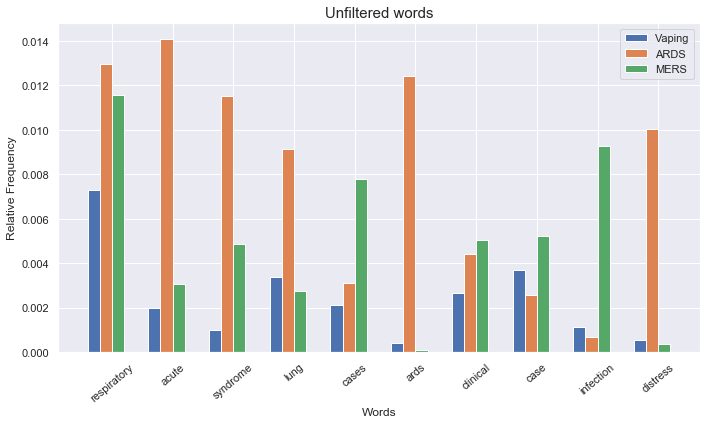

In [29]:
frequencies_by_category = get_frequencies_by_category(pdfs_text)
total_df = aggregate_data(frequencies_by_category, scale_by_category=True)
plot_bars(total_df[:10], "Unfiltered words")

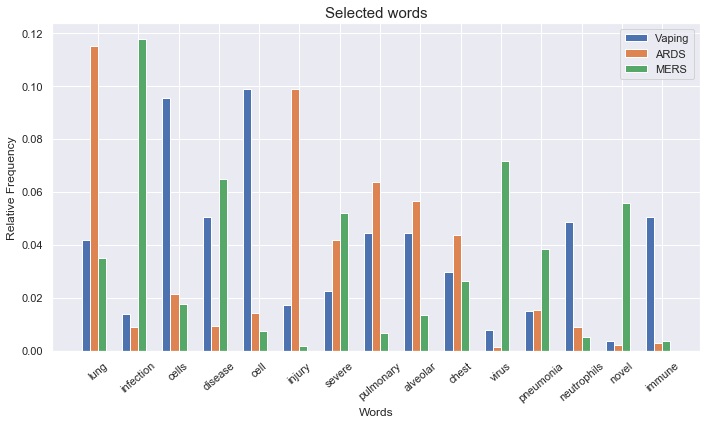

In [30]:
frequencies_by_category = get_frequencies_by_category(pdfs_text, use_whitelist = True)
total_df = aggregate_data(frequencies_by_category, scale_by_category=True)
plot_bars(total_df[:15], "Selected words")

# Other

Unused code

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pdfs_text.values())

In [ ]:
x = X.toarray()

In [ ]:
features = np.array(vectorizer.get_feature_names())

In [ ]:
stop_words = set()
# stop_words = set(features[x.max(axis = 0) < 0.1])
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({str(x) for x in range(100)})

In [ ]:
tokens = []

for text in pdfs_text.values():
    for token in nltk.tokenize.word_tokenize(text):
        if token not in stop_words:
            tokens.append(token)

fd = nltk.FreqDist(tokens)

In [ ]:
# fd.most_common()

for word, freq in fd.most_common()[:5]:
    plt.bar(word, freq)

## Spacy Stuff

In [5]:
nlp = spacy.load("en_core_web_md")
doc = nlp(pdfs_text[('vaping', '2012_0.pdf')])

In [15]:
get_tokens_from_text(pdfs_text[('vaping', '2012_0.pdf')])

['chest',
 'electronic',
 'cigarettes',
 'thing',
 'free',
 'lunch…or',
 'puff',
 'pulmonary',
 'cardiac',
 'mediascine',
 'practitioners',
 'many',
 'us',
 'doubt',
 'asked',
 'patients',
 'smoke',
 'so-called',
 '“',
 'electronic',
 'cigarettes',
 '”',
 'e-cigarettes',
 'devices',
 'termed',
 'electronic',
 'nicotine',
 'delivery',
 'systems',
 'ends',
 'world',
 'health',
 'organization',
 'available',
 'us',
 'market',
 'since',
 '2007.',
 'patients',
 'likely',
 'heard',
 'far',
 'devices',
 'marketing',
 'chat',
 'rooms',
 'word',
 'mouth',
 'physicians',
 'medical',
 'literature',
 'ends',
 'currently',
 'regulated',
 'us',
 'food',
 'drug',
 'administration',
 'fda',
 'medical',
 'devices—',
 'recent',
 'court',
 'decisions',
 'denied',
 'agency',
 'right',
 'oversight—manufacturers',
 'ends',
 'required',
 'establish',
 'either',
 'safety',
 'efﬁ',
 'ﬁcacy',
 'data',
 'answer',
 'patients',
 '’',
 'queries',
 'products',
 'e-cigarettes',
 'smoking',
 'cessation',
 'tool',
 'ha

In [8]:
displacy.render(doc, style="ent")